# Download Dataset

In [ ]:
!wget --no-check-certificate \
    "https://d17h27t6h515a5.cloudfront.net/topher/2016/December/584f6edd_data/data.zip" \
    -O "/content/end-to-end-dataset.zip"

--2023-08-10 11:43:28--  https://d17h27t6h515a5.cloudfront.net/topher/2016/December/584f6edd_data/data.zip
Resolving d17h27t6h515a5.cloudfront.net (d17h27t6h515a5.cloudfront.net)... 13.249.90.78, 13.249.90.229, 13.249.90.90, ...
Connecting to d17h27t6h515a5.cloudfront.net (d17h27t6h515a5.cloudfront.net)|13.249.90.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 333137665 (318M) [application/zip]
Saving to: ‘/content/end-to-end-dataset.zip’

/content/end-to-end 100%[===================>] 317.70M  42.7MB/s    in 6.5s    

2023-08-10 11:43:34 (48.5 MB/s) - ‘/content/end-to-end-dataset.zip’ saved [333137665/333137665]



In [ ]:
!unzip -xq '/content/end-to-end-dataset.zip'

In [ ]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.6/731.6 kB 4.1 MB/s eta 0:00:00


# imports

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms, models

from tqdm.notebook import tqdm
from torchmetrics import R2Score

# Init

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
BATCH_SIZE = 256

# checking dataset

In [ ]:
df = pd.read_csv('/content/data/driving_log.csv')
df

,center,left,right,steering,throttle,brake,speed
0,IMG/center_2016_12_01_13_30_48_287.jpg,IMG/left_2016_12_01_13_30_48_287.jpg,IMG/right_2016_12_01_13_30_48_287.jpg,0.0,0.0,0.0,22.148290
1,IMG/center_2016_12_01_13_30_48_404.jpg,IMG/left_2016_12_01_13_30_48_404.jpg,IMG/right_2016_12_01_13_30_48_404.jpg,0.0,0.0,0.0,21.879630
2,IMG/center_2016_12_01_13_31_12_937.jpg,IMG/left_2016_12_01_13_31_12_937.jpg,IMG/right_2016_12_01_13_31_12_937.jpg,0.0,0.0,0.0,1.453011
3,IMG/center_2016_12_01_13_31_13_037.jpg,IMG/left_2016_12_01_13_31_13_037.jpg,IMG/right_2016_12_01_13_31_13_037.jpg,0.0,0.0,0.0,1.438419
4,IMG/center_2016_12_01_13_31_13_177.jpg,IMG/left_2016_12_01_13_31_13_177.jpg,IMG/right_2016_12_01_13_31_13_177.jpg,0.0,0.0,0.0,1.418236
...,...,...,...,...,...,...,...
8031,IMG/center_2016_12_01_13_46_38_745.jpg,IMG/left_2016_12_01_13_46_38_745.jpg,IMG/right_2016_12_01_13_46_38_745.jpg,0.0,0.0,0.0,1.402436
8032,IMG/center_2016_12_01_13_46_38_802.jpg,IMG/left_2016_12_01_13_46_38_802.jpg,IMG/right_2016_12_01_13_46_38_802.jpg,0.0,0.0,0.0,1.393976
8033,IMG/center_2016_12_01_13_46_38_846.jpg,IMG/left_2016_12_01_13_46_38_846.jpg,IMG/right_2016_12_01_13_46_38_846.jpg,0.0,0.0,0.0,1.388364
8034,IMG/center_2016_12_01_13_46_38_922.jpg,IMG/left_2016_12_01_13_46_38_922.jpg,IMG/right_2016_12_01_13_46_38_922.jpg,0.0,0.0,0.0,1.377208


In [ ]:
df['center'] = df['center'].apply(lambda x: x.split('/')[1])
df['left'] = df['left'].apply(lambda x: x.split('/')[1])
df['right'] = df['right'].apply(lambda x: x.split('/')[1])

In [ ]:
df.head()

,center,left,right,steering,throttle,brake,speed
0,center_2016_12_01_13_30_48_287.jpg,left_2016_12_01_13_30_48_287.jpg,right_2016_12_01_13_30_48_287.jpg,0.0,0.0,0.0,22.148290
1,center_2016_12_01_13_30_48_404.jpg,left_2016_12_01_13_30_48_404.jpg,right_2016_12_01_13_30_48_404.jpg,0.0,0.0,0.0,21.879630
2,center_2016_12_01_13_31_12_937.jpg,left_2016_12_01_13_31_12_937.jpg,right_2016_12_01_13_31_12_937.jpg,0.0,0.0,0.0,1.453011
3,center_2016_12_01_13_31_13_037.jpg,left_2016_12_01_13_31_13_037.jpg,right_2016_12_01_13_31_13_037.jpg,0.0,0.0,0.0,1.438419
4,center_2016_12_01_13_31_13_177.jpg,left_2016_12_01_13_31_13_177.jpg,right_2016_12_01_13_31_13_177.jpg,0.0,0.0,0.0,1.418236


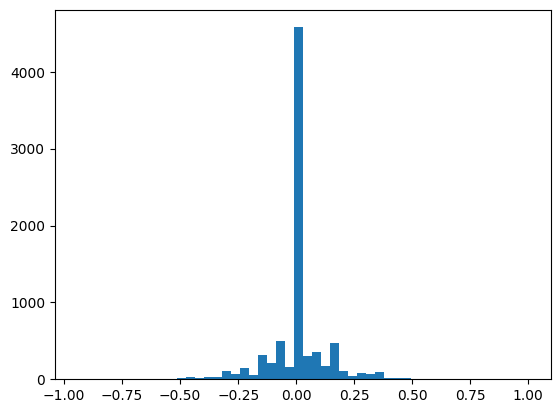

In [ ]:
plt.hist(df['steering'], bins=50);

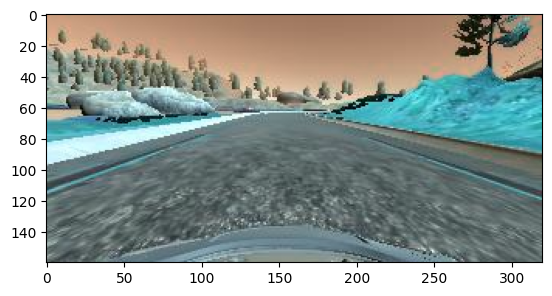

In [ ]:
images = os.listdir('/content/data/IMG')
img = cv2.imread((os.path.join('/content/data/IMG', images[2])))
plt.imshow(img)

# custom dataset

In [ ]:
class StreeringWheel(Dataset):
  def __init__(self, root, df, transform):
    self.df = df
    self.root = root
    self.images = os.listdir(self.root)
    self.transform = transform

  def __getitem__(self, idx):
    path = os.path.join(self.root, self.images[idx])
    img = Image.open(path)

    if self.transform is not None:
      img = self.transform(img)

    col = images[idx].split('_')[0]
    label = torch.tensor(df['steering'][df[col] == images[idx]].values, dtype=torch.float32)

    return img, label

  def __len__(self):
    return len(self.images)

In [ ]:
transform = transforms.Compose([
    transforms.Resize((66, 200)),
    transforms.ToTensor()
])

dataset = StreeringWheel(root = '/content/data/IMG', df=df, transform=transform)

In [ ]:
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

In [ ]:
x, y = next(iter(dataloader))
print('X shape is:', x.shape, x.dtype)
print('y shape is:', y.shape, y.dtype)

X shape is: torch.Size([64, 3, 66, 200]) torch.float32
y shape is: torch.Size([64, 1]) torch.float32


# Train Test Split

In [ ]:
train_dataset, valid_dataset = random_split(dataset, [17000, (len(dataset) - 17000)])
print(len(train_dataset)), print(len(valid_dataset))

17000
7108


(None, None)

In [ ]:
trainloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
testloader  = DataLoader(valid_dataset, batch_size=BATCH_SIZE*3, shuffle=True)

# Netwrok

In [ ]:
class Model(nn.Module):
  def __init__(self):
    super(Model, self).__init__()
    self.conv_block = nn.Sequential(nn.BatchNorm2d(3),
                      nn.Conv2d(3, 24, kernel_size=(5,5), stride=(2,2)),
                      nn.ReLU(),
                      nn.Conv2d(24, 36, kernel_size=(5,5), stride=(2,2)),
                      nn.ReLU(),
                      nn.Conv2d(36, 48, kernel_size=(5,5), stride=(2,2)),
                      nn.ReLU(),
                      nn.Conv2d(48, 64, kernel_size=(3,3)),
                      nn.ReLU(),
                      nn.Conv2d(64, 64, kernel_size=(3,3)),
                      nn.ReLU(),
           )

    self.cls = nn.Sequential(
                    nn.Flatten(),
                    nn.Linear(64*18, 1164),
                    nn.ReLU(),
                    nn.Dropout(0.3),
                    nn.Linear(1164, 100),
                    nn.ReLU(),
                    nn.Dropout(0.2),
                    nn.Linear(100, 50),
                    nn.ReLU(),
                    nn.Dropout(0.1),
                    nn.Linear(50, 10),
                    nn.ReLU(),
                    nn.Dropout(0.1),
                    nn.Linear(10, 1)
    )

  def forward(self, x):
    y = self.conv_block(x)
    y = self.cls(y)
    return y

In [ ]:
class Model(nn.Module):
  def __init__(self):
    super(Model, self).__init__()
    self.base = models.resnet18()
    self.base.fc = nn.Linear(512, 1)

  def forward(self, x):
    return self.base(x)

In [ ]:
model = Model().to(device)

In [ ]:
output = model(torch.randn(5, 3, 66, 200).to(device))
output.shape

torch.Size([5, 1])

# utils

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, epoch):
  model.train()
  loss_train = AverageMeter()
  r2score = R2Score().to(device)
  with tqdm(train_loader, unit='batch') as tepoch:
    for inputs, targets in tepoch:
      if epoch is not None:
        tepoch.set_description(f'Epoch {epoch}')
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)
      loss = loss_fn(outputs, targets)

      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      loss_train.update(loss.item())
      r2 = r2score(outputs, targets)

      tepoch.set_postfix(loss=loss_train.avg, r2 = 100.*r2.item())
  return model, loss_train.avg , r2.item()

In [ ]:
def evaluate(model, valid_loader, loss_fn):
  model.eval()
  with torch.no_grad():
    loss_valid = AverageMeter()
    r2score = R2Score().to(device)
    for i, (inputs, targets) in enumerate(valid_loader):
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)
      loss = loss_fn(outputs, targets)

      loss_valid.update(loss.item())
      r2 = r2score(outputs, targets)

  return loss_valid.avg , r2.item()


In [ ]:
def count_parameters(model):
    params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return params/1000000

# Loss Function and Optimizer

In [ ]:
loss_fn = nn.MSELoss()
model = Model().to(device)

opt = torch.optim.Adam(params = model.parameters(), lr=0.0001)
count_parameters(model)

11.177025

# Training

## Checking forward path

In [ ]:
x, y = next(iter(trainloader))
x, y = x.to(device), y.to(device)
pred = model(x)
loss = loss_fn(y, pred)
loss

tensor(0.0355, device='cuda:0', grad_fn=<MseLossBackward0>)

## Checking backward path

In [ ]:
mini_batch, _ = random_split(train_dataset, [2000, len(train_dataset) - 2000])
miniloader = DataLoader(mini_batch, batch_size = 64)

In [ ]:
for i in range(100):
  model, _ , _= train_one_epoch(epoch=i, loss_fn=loss_fn, model=model, optimizer=opt, train_loader = miniloader)

  0%|          | 0/32 [00:00<?, ?batch/s]

  0%|          | 0/32 [00:00<?, ?batch/s]

  0%|          | 0/32 [00:00<?, ?batch/s]

  0%|          | 0/32 [00:00<?, ?batch/s]

  0%|          | 0/32 [00:00<?, ?batch/s]

  0%|          | 0/32 [00:00<?, ?batch/s]

  0%|          | 0/32 [00:00<?, ?batch/s]

  0%|          | 0/32 [00:00<?, ?batch/s]

  0%|          | 0/32 [00:00<?, ?batch/s]

  0%|          | 0/32 [00:00<?, ?batch/s]

  0%|          | 0/32 [00:00<?, ?batch/s]

  0%|          | 0/32 [00:00<?, ?batch/s]

  0%|          | 0/32 [00:00<?, ?batch/s]

  0%|          | 0/32 [00:00<?, ?batch/s]

  0%|          | 0/32 [00:00<?, ?batch/s]

  0%|          | 0/32 [00:00<?, ?batch/s]

  0%|          | 0/32 [00:00<?, ?batch/s]

  0%|          | 0/32 [00:00<?, ?batch/s]

  0%|          | 0/32 [00:00<?, ?batch/s]

  0%|          | 0/32 [00:00<?, ?batch/s]

  0%|          | 0/32 [00:00<?, ?batch/s]

  0%|          | 0/32 [00:00<?, ?batch/s]

  0%|          | 0/32 [00:00<?, ?batch/s]

  0%|          | 0/32 [00:00<?, ?batch/s]

  0%|          | 0/32 [00:00<?, ?batch/s]

  0%|          | 0/32 [00:00<?, ?batch/s]

  0%|          | 0/32 [00:00<?, ?batch/s]

  0%|          | 0/32 [00:00<?, ?batch/s]

  0%|          | 0/32 [00:00<?, ?batch/s]

  0%|          | 0/32 [00:00<?, ?batch/s]

  0%|          | 0/32 [00:00<?, ?batch/s]

  0%|          | 0/32 [00:00<?, ?batch/s]

  0%|          | 0/32 [00:00<?, ?batch/s]

  0%|          | 0/32 [00:00<?, ?batch/s]

  0%|          | 0/32 [00:00<?, ?batch/s]

  0%|          | 0/32 [00:00<?, ?batch/s]

  0%|          | 0/32 [00:00<?, ?batch/s]

  0%|          | 0/32 [00:00<?, ?batch/s]

  0%|          | 0/32 [00:00<?, ?batch/s]

  0%|          | 0/32 [00:00<?, ?batch/s]

  0%|          | 0/32 [00:00<?, ?batch/s]

  0%|          | 0/32 [00:00<?, ?batch/s]

  0%|          | 0/32 [00:00<?, ?batch/s]

  0%|          | 0/32 [00:00<?, ?batch/s]

  0%|          | 0/32 [00:00<?, ?batch/s]

  0%|          | 0/32 [00:00<?, ?batch/s]

  0%|          | 0/32 [00:00<?, ?batch/s]

  0%|          | 0/32 [00:00<?, ?batch/s]

  0%|          | 0/32 [00:00<?, ?batch/s]

  0%|          | 0/32 [00:00<?, ?batch/s]

  0%|          | 0/32 [00:00<?, ?batch/s]

  0%|          | 0/32 [00:00<?, ?batch/s]

  0%|          | 0/32 [00:00<?, ?batch/s]

  0%|          | 0/32 [00:00<?, ?batch/s]

  0%|          | 0/32 [00:00<?, ?batch/s]

  0%|          | 0/32 [00:00<?, ?batch/s]

  0%|          | 0/32 [00:00<?, ?batch/s]

  0%|          | 0/32 [00:00<?, ?batch/s]

  0%|          | 0/32 [00:00<?, ?batch/s]

  0%|          | 0/32 [00:00<?, ?batch/s]

  0%|          | 0/32 [00:00<?, ?batch/s]

  0%|          | 0/32 [00:00<?, ?batch/s]

  0%|          | 0/32 [00:00<?, ?batch/s]

  0%|          | 0/32 [00:00<?, ?batch/s]

  0%|          | 0/32 [00:00<?, ?batch/s]

  0%|          | 0/32 [00:00<?, ?batch/s]

  0%|          | 0/32 [00:00<?, ?batch/s]

  0%|          | 0/32 [00:00<?, ?batch/s]

  0%|          | 0/32 [00:00<?, ?batch/s]

  0%|          | 0/32 [00:00<?, ?batch/s]

  0%|          | 0/32 [00:00<?, ?batch/s]

  0%|          | 0/32 [00:00<?, ?batch/s]

  0%|          | 0/32 [00:00<?, ?batch/s]

  0%|          | 0/32 [00:00<?, ?batch/s]

  0%|          | 0/32 [00:00<?, ?batch/s]

  0%|          | 0/32 [00:00<?, ?batch/s]

  0%|          | 0/32 [00:00<?, ?batch/s]

  0%|          | 0/32 [00:00<?, ?batch/s]

  0%|          | 0/32 [00:00<?, ?batch/s]

  0%|          | 0/32 [00:00<?, ?batch/s]

  0%|          | 0/32 [00:00<?, ?batch/s]

  0%|          | 0/32 [00:00<?, ?batch/s]

  0%|          | 0/32 [00:00<?, ?batch/s]

  0%|          | 0/32 [00:00<?, ?batch/s]

  0%|          | 0/32 [00:00<?, ?batch/s]

  0%|          | 0/32 [00:00<?, ?batch/s]

  0%|          | 0/32 [00:00<?, ?batch/s]

  0%|          | 0/32 [00:00<?, ?batch/s]

  0%|          | 0/32 [00:00<?, ?batch/s]

  0%|          | 0/32 [00:00<?, ?batch/s]

  0%|          | 0/32 [00:00<?, ?batch/s]

  0%|          | 0/32 [00:00<?, ?batch/s]

  0%|          | 0/32 [00:00<?, ?batch/s]

  0%|          | 0/32 [00:00<?, ?batch/s]

  0%|          | 0/32 [00:00<?, ?batch/s]

  0%|          | 0/32 [00:00<?, ?batch/s]

  0%|          | 0/32 [00:00<?, ?batch/s]

  0%|          | 0/32 [00:00<?, ?batch/s]

  0%|          | 0/32 [00:00<?, ?batch/s]

  0%|          | 0/32 [00:00<?, ?batch/s]

## Learning Rate

In [ ]:
lrs = [0.1, 0.01, 0.001, 0.0001, 0.00001]
for lr in lrs:

  model = Model().to(device)
  opt = torch.optim.Adam(params = model.parameters(), lr=lr)
  print(lr)
  for i in range(3):
    model, _, _ = train_one_epoch(epoch=i, loss_fn=loss_fn, model=model, optimizer=opt, train_loader=trainloader)

  print()

0.1


  0%|          | 0/67 [00:00<?, ?batch/s]

  0%|          | 0/67 [00:00<?, ?batch/s]

  0%|          | 0/67 [00:00<?, ?batch/s]


0.01


  0%|          | 0/67 [00:00<?, ?batch/s]

  0%|          | 0/67 [00:00<?, ?batch/s]

  0%|          | 0/67 [00:00<?, ?batch/s]


0.001


  0%|          | 0/67 [00:00<?, ?batch/s]

  0%|          | 0/67 [00:00<?, ?batch/s]

  0%|          | 0/67 [00:00<?, ?batch/s]


0.0001


  0%|          | 0/67 [00:00<?, ?batch/s]

  0%|          | 0/67 [00:00<?, ?batch/s]

  0%|          | 0/67 [00:00<?, ?batch/s]


1e-05


  0%|          | 0/67 [00:00<?, ?batch/s]

  0%|          | 0/67 [00:00<?, ?batch/s]

  0%|          | 0/67 [00:00<?, ?batch/s]

## Train

In [ ]:
model = Model().to(device)
opt = torch.optim.Adam(params = model.parameters(), lr=0.0001)

In [ ]:
loss_train_hist = []
loss_test_hist = []

r2_score_train_hist = []
r2_score_test_hist = []

best_loss_valid = torch.inf
epoch_counter = 0

num_epoch = 200

In [ ]:
for epoch in range(num_epoch):
  model, loss_train, r2_train = train_one_epoch(epoch=epoch, loss_fn=loss_fn, model=model, optimizer=opt, train_loader=trainloader)
  loss_valid, r2_test = evaluate(model, testloader, loss_fn)

  epoch_counter += 1

  loss_train_hist.append(loss_train)
  loss_test_hist.append(loss_valid)

  r2_score_train_hist.append(r2_train)
  r2_score_test_hist.append(r2_test)

  if loss_valid < best_loss_valid:
    best_loss_valid = loss_valid
    print('better loss detected')
    epoch_counter = 0

  print(f"valid: loss{loss_valid:0.4f}, r2:{r2_test:0.4f}")
  print()

  if epoch_counter >= 5 :
    print('No Better results recieved')
    break

  0%|          | 0/67 [00:00<?, ?batch/s]

better loss detected
valid: loss0.0122, r2:0.2909



  0%|          | 0/67 [00:00<?, ?batch/s]

better loss detected
valid: loss0.0114, r2:0.4602



  0%|          | 0/67 [00:00<?, ?batch/s]

better loss detected
valid: loss0.0097, r2:0.3941



  0%|          | 0/67 [00:00<?, ?batch/s]

valid: loss0.0101, r2:0.3579



  0%|          | 0/67 [00:00<?, ?batch/s]

better loss detected
valid: loss0.0094, r2:0.4824



  0%|          | 0/67 [00:00<?, ?batch/s]

valid: loss0.0100, r2:0.2298



  0%|          | 0/67 [00:00<?, ?batch/s]

better loss detected
valid: loss0.0094, r2:0.5023



  0%|          | 0/67 [00:00<?, ?batch/s]

valid: loss0.0104, r2:0.4128



  0%|          | 0/67 [00:00<?, ?batch/s]

better loss detected
valid: loss0.0092, r2:0.4032



  0%|          | 0/67 [00:00<?, ?batch/s]

better loss detected
valid: loss0.0091, r2:0.5295



  0%|          | 0/67 [00:00<?, ?batch/s]

valid: loss0.0094, r2:0.5086



  0%|          | 0/67 [00:00<?, ?batch/s]

better loss detected
valid: loss0.0090, r2:0.4609



  0%|          | 0/67 [00:00<?, ?batch/s]

valid: loss0.0092, r2:0.5908



  0%|          | 0/67 [00:00<?, ?batch/s]

better loss detected
valid: loss0.0089, r2:0.5743



  0%|          | 0/67 [00:00<?, ?batch/s]

better loss detected
valid: loss0.0088, r2:0.4960



  0%|          | 0/67 [00:00<?, ?batch/s]

better loss detected
valid: loss0.0086, r2:0.5626



  0%|          | 0/67 [00:00<?, ?batch/s]

better loss detected
valid: loss0.0086, r2:0.5841



  0%|          | 0/67 [00:00<?, ?batch/s]

better loss detected
valid: loss0.0081, r2:0.5438



  0%|          | 0/67 [00:00<?, ?batch/s]

valid: loss0.0088, r2:0.5922



  0%|          | 0/67 [00:00<?, ?batch/s]

valid: loss0.0095, r2:0.4546



  0%|          | 0/67 [00:00<?, ?batch/s]

valid: loss0.0096, r2:0.4737



  0%|          | 0/67 [00:00<?, ?batch/s]

valid: loss0.0082, r2:0.5902



  0%|          | 0/67 [00:00<?, ?batch/s]

valid: loss0.0085, r2:0.5455

No Better results recieved


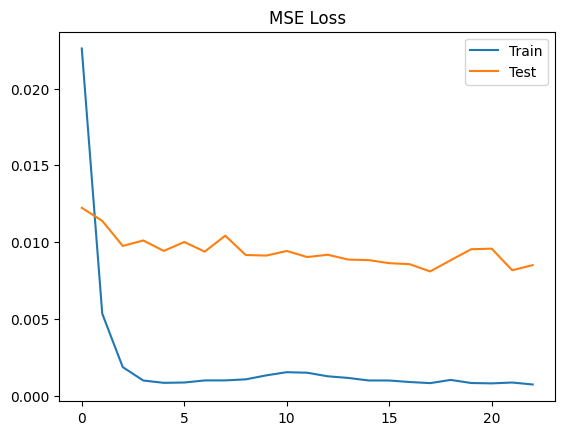

In [ ]:
# ResNet

plt.plot(loss_train_hist, label='Train')
plt.plot(loss_test_hist, label='Test')
plt.title('MSE Loss')
plt.legend()

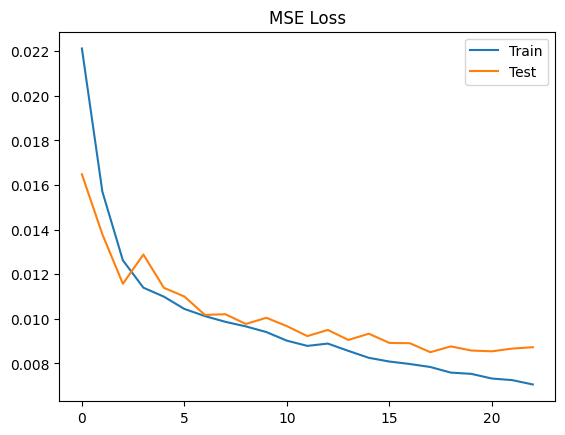

In [ ]:
plt.plot(loss_train_hist, label='Train')
plt.plot(loss_test_hist, label='Test')
plt.title('MSE Loss')
plt.legend()

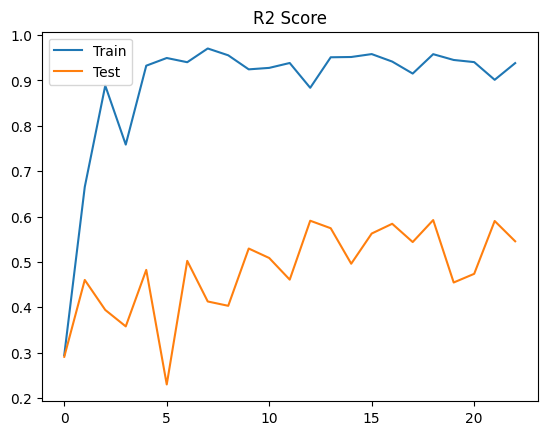

In [ ]:
# ResNet

plt.plot(r2_score_train_hist, label='Train')
plt.plot(r2_score_test_hist, label='Test')
plt.title('R2 Score')
plt.legend()

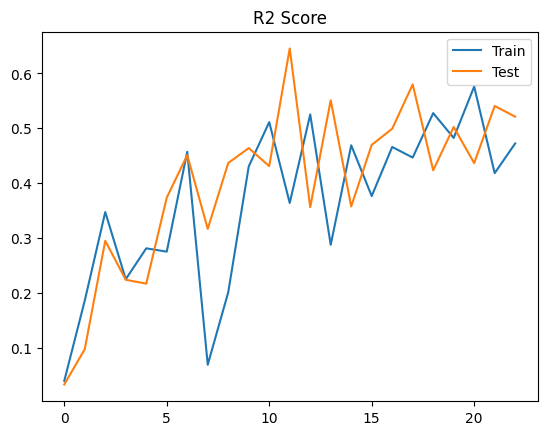

In [ ]:
plt.plot(r2_score_train_hist, label='Train')
plt.plot(r2_score_test_hist, label='Test')
plt.title('R2 Score')
plt.legend()